# MCMC examples: $\tau_{int}$, $p_{xy}$, and the `cov` argument to `MHSampler`
### gully  
February 2016  

The main goal here is to gain some experience with the Metropolis-Hasting Sampler-- specifically the transition probability matrix that controls the probabilities of transition from one state $x$ to another $y$ through $p_{xy}$.  This matrix is the `cov` argument to the `MHSampler(Sampler)` class.  We also want to estimate $\tau_{int}$, which is the integrated autocorrelation time.  We accomplish both of these goals in this Notebook, which relies heavily on the Sokal 1996 notes, and the emcee [examples](http://dan.iel.fm/emcee/current/user/line/) and Documentation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y_true = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [3]:
sns.set_style('ticks')

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


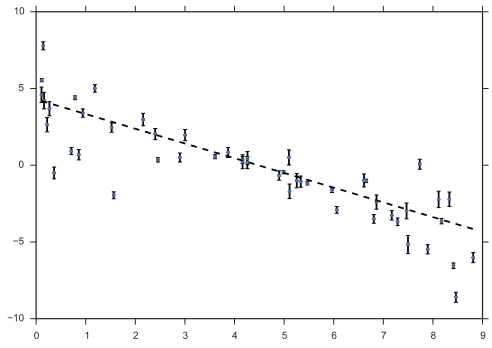

In [4]:
plt.errorbar(x, y, yerr=yerr, fmt='.k', capsize=2, capthick=1, barsabove=True)
plt.plot(x, y, '.')

plt.plot(x, y_true, 'k--')

In [5]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

In [6]:
b_true, m_true

(4.294, -0.9594)

In [7]:
b_ls, m_ls

(4.5716783658860551, -1.0731968547515647)

### Maximum Likelihood

In [8]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [9]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [10]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [11]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [12]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

### Emcee

In [13]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [14]:
cov = np.diagflat([0.05**2, 0.20**2, 0.02**2])

In [15]:
sampler2 = emcee.MHSampler(cov, ndim, lnprob, args=(x, y, yerr))

In [16]:
# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, 500, rstate0=np.random.get_state())
print("Done.")

Running MCMC...
Done.


In [17]:
# Clear and run the production chain.
print("Running MCMC...")
pos0 = np.array([-0.85676816,  3.88503517, -0.40343935])
sampler2.run_mcmc(pos0, 500, rstate0=np.random.get_state())
print("Done.")

Running MCMC...
Done.


In [18]:
from matplotlib.ticker import MaxNLocator

In [19]:
plt.clf()
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 7.5))
axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
axes[0].plot(sampler2.chain[:, 0].T, color="r", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(m_true, color="#888888", lw=2)
axes[0].set_ylabel("$m$")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
axes[1].plot(sampler2.chain[:, 1].T, color="r", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(b_true, color="#888888", lw=2)
axes[1].set_ylabel("$b$")

axes[2].plot(np.exp(sampler.chain[:, :, 2]).T, color="k", alpha=0.4)
axes[2].plot(np.exp(sampler2.chain[:, 2]).T, color="r", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(f_true, color="#888888", lw=2)
axes[2].set_ylabel("$f$")
axes[2].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)
fig.savefig("line-time.png")

### Run longer

In [20]:
sampler2.reset()

In [21]:
# Clear and run the production chain.
print("Running MCMC...")
pos0 = np.array([-0.85676816,  3.88503517, -0.40343935])
sampler2.run_mcmc(pos0, 100000, rstate0=np.random.get_state())
print("Done.")

Running MCMC...
Done.


Code to make a 100000 sample long MCMC chain figure:

```python
plt.clf()
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 7.5))

axes[0].plot(sampler2.chain[:, 0].T, color="r", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(m_true, color="#888888", lw=2)
axes[0].set_ylabel("$m$")

axes[1].plot(sampler2.chain[:, 1].T, color="r", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(b_true, color="#888888", lw=2)
axes[1].set_ylabel("$b$")

axes[2].plot(np.exp(sampler2.chain[:, 2]).T, color="r", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(f_true, color="#888888", lw=2)
axes[2].set_ylabel("$f$")
axes[2].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)
fig.savefig("line-time_MH.png")
```

The bottom one looks *correlated*.  

What is the autocorrelation?  
*See Sokal 1996 notes about MCMC to answer the question of the optimal window size.*  
Roughly speaking we want a window size of about 6-10 times the estimate of $\hat \tau_{int}$.

Discard the first $n_{disc}$ samples.  This is called the *burn in*.  
$n_{disc} \sim 20 \tau_{exp}$  
$\tau_{exp} \sim \tau_{int} \sim 300$

In [23]:
n_disc = 20.0*300.0
chain = sampler2.chain[n_disc:, 2]

print("{: <8} {: <8} {: <8}".format("window", "tau_int", "x6"))
for w in [50*2**n for n in range(10)]:
    tau_int = emcee.autocorr.integrated_time(chain, window=w)
    print("{:.>8} {:.>8.1f} {:.>8.1f} ".format(w, tau_int, 6.0*tau_int))

window   tau_int  x6      
......50 ....89.9 ...539.6 
.....100 ...165.0 ...990.1 
.....200 ...279.7 ..1678.0 
.....400 ...420.7 ..2524.3 
.....800 ...512.6 ..3075.7 
....1600 ...564.6 ..3387.5 
....3200 ...444.8 ..2668.5 
....6400 ...640.4 ..3842.3 
...12800 ...578.0 ..3468.3 
...25600 ...539.9 ..3239.6 


//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


So the window sizes should be about 2000, 2000, and 4000 respectively, giving:

In [24]:
te = emcee.autocorr.integrated_time

In [25]:
n_disc = int(20.0*300.0)

In [26]:
te(sampler2.chain[n_disc:, 0], window=2000), te(sampler2.chain[n_disc:, 1], window=2000), te(sampler2.chain[n_disc:, 2], window=4000), 


(207.53827382112965, 189.9795635766213, 381.44104439109429)

## Estimate covariance and then re-run MCMC!

The chains are **covariant**, meaning there are non-zero off-diagonal terms in the covariance matrix.  Another way of thinking about this is that the axes of greatest variance are not perfectly aligned with the parameter axes.  Yet another way of thinking about this is that the chains have predictable patterns and statistical relationships to one another- when one chain goes one way, another chain has some enhanced or degraded chance of going in the same direction.  *capiche?*

Let's use the chain we just made and estimate, characterize, and employ the covariance matrix.

In [27]:
new_cov = np.cov(sampler2.chain[n_disc:,], rowvar=0)

In [28]:
new_cov

array([[ 0.00765176, -0.03474109,  0.00609366],
       [-0.03474109,  0.1671507 , -0.02694879],
       [ 0.00609366, -0.02694879,  0.0164966 ]])

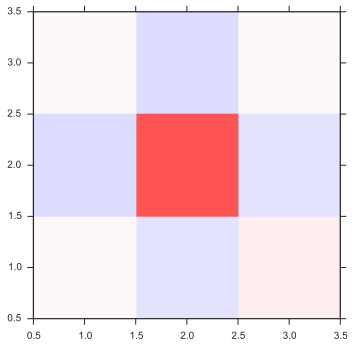

In [29]:
d = ndim
ext = (0.5, d + 0.5, 0.5, d + 0.5)
plt.imshow(new_cov, origin="upper", vmin=-0.25, vmax=0.25, cmap="bwr", interpolation='nearest', extent=ext)

Here's what a 3D multivariate Gaussian looks like, with that covariance structure:

In [30]:
from mpl_toolkits.mplot3d import Axes3D

In [31]:
m_true = -0.9594
b_true = 4.294
f_true = 0.534

In [32]:
mean_vals = [m_true, b_true, f_true]
chain_raw = np.array([sampler2.chain[n_disc:, 0], sampler2.chain[n_disc:, 1], np.exp(sampler2.chain[n_disc:, 2])])
chain = chain_raw.T

In [33]:
chain.shape

(94000, 3)

In [34]:
cov_orig_units = np.cov(chain, rowvar=0)

In [35]:
n_samps = 365
cov_samps = np.random.mtrand.multivariate_normal(mean_vals, cov_orig_units, n_samps)

In [36]:
evals, evecs = np.linalg.eigh(cov_orig_units)

In [37]:
evals

array([ 0.00039351,  0.00457837,  0.17609074])

In [38]:
np.linalg.norm(evecs[0]) #unit vectors.

1.0000000000000004

In [39]:
! mkdir anim_3D

mkdir: anim_3D: File exists


### (Code to make a completely irrelevant animated movie of multivariate normal with covariance).

```python
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(m_true, b_true, f_true, c='b', marker='*', s=300)
ax.plot([m_true, m_true+evecs[0, 0]], [b_true, b_true+evecs[0, 1]], [f_true, f_true+evecs[0, 2]], 'k-')
ax.plot([m_true, m_true+evecs[1, 0]], [b_true, b_true+evecs[1, 1]], [f_true, f_true+evecs[1, 2]], 'k-')
ax.plot([m_true, m_true+evecs[2, 0]], [b_true, b_true+evecs[2, 1]], [f_true, f_true+evecs[2, 2]], 'k-')
#ax.plot([m_true, m_true+5*evals[0]*evecs[0, 0]], [b_true, b_true+5*evals[1]*evecs[0, 1]], [f_true, f_true+5*evals[2]*evecs[0, 2]], 'k-')
#ax.plot([m_true, m_true+5*evals[0]*evecs[1, 0]], [b_true, b_true+5*evals[1]*evecs[1, 1]], [f_true, f_true+5*evals[2]*evecs[1, 2]], 'k-')
#ax.plot([m_true, m_true+5*evals[0]*evecs[2, 0]], [b_true, b_true+5*evals[1]*evecs[2, 1]], [f_true, f_true+5*evals[2]*evecs[2, 2]], 'k-')

ax.set_xlabel('$m$')
ax.set_ylabel('$b$')
ax.set_zlabel('$f$')
ax.set_xlim(-2, 0)
ax.set_ylim(0, 10)
ax.set_zlim(0, 1)

for i in np.arange(0, 360, 1):
    x, y, z = cov_samps[i, 0], cov_samps[i, 1], cov_samps[i, 2]
    ax.scatter(x, y, z, c='r', marker='o')
    
    ax.view_init(30, i)
    plt.savefig('anim_3D/cov{:04d}.png'.format(i))
```

In [40]:
#! ffmpeg -framerate 10 -i cov%4d.png -c:v libx264 -pix_fmt yuv420p test.mp4

### Run the sampler with the covariance structure.

In [41]:
sampler3 = emcee.MHSampler(new_cov, ndim, lnprob, args=(x, y, yerr))

In [42]:
print("Running MCMC...")
pos0 = np.array([m_true,  b_true, f_true])
sampler3.run_mcmc(pos0, 5000, rstate0=np.random.get_state())
print('Done.')

Running MCMC...
Done.


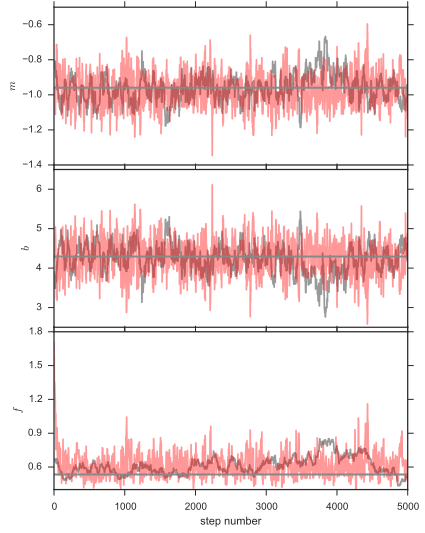

In [43]:
plt.clf()
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 7.5))
axes[0].plot(sampler2.chain[0:5000, 0].T, color="k", alpha=0.4)
axes[0].plot(sampler3.chain[:, 0].T, color="r", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(m_true, color="#888888", lw=2)
axes[0].set_ylabel("$m$")

axes[1].plot(sampler2.chain[0:5000, 1].T, color="k", alpha=0.4)
axes[1].plot(sampler3.chain[:, 1].T, color="r", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(b_true, color="#888888", lw=2)
axes[1].set_ylabel("$b$")

axes[2].plot(np.exp(sampler2.chain[0:5000, 2]).T, color="k", alpha=0.4)
axes[2].plot(np.exp(sampler3.chain[:, 2]).T, color="r", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(f_true, color="#888888", lw=2)
axes[2].set_ylabel("$f$")
axes[2].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)
fig.savefig("line-time.png")

The **gray line** is the Metropolis-Hastings sampling with **no off-diagonal terms** in the covariance matrix.  
The **red line**  is the Metropolis-Hastings sampling using the proper **covariance matrix**.

## Run longer

In [44]:
sampler3.reset()

In [45]:
print("Running MCMC...")
pos0 = np.array([m_true,  b_true, f_true])
sampler3.run_mcmc(pos0, 100000, rstate0=np.random.get_state())
print('Done.')

Running MCMC...
Done.


In [46]:
n_disc = 20.0*300.0
chain = sampler3.chain[n_disc:, 2]

print("{: <8} {: <8} {: <8}".format("window", "tau_int", "x6"))
for w in [50*2**n for n in range(10)]:
    tau_int = emcee.autocorr.integrated_time(chain, window=w)
    print("{:.>8} {:.>8.1f} {:.>8.1f} ".format(w, tau_int, 6.0*tau_int))

window   tau_int  x6      
......50 ....15.2 ....90.9 
.....100 ....15.0 ....89.8 
.....200 ....16.5 ....99.3 
.....400 ....15.5 ....92.8 
.....800 ....19.2 ...115.2 
....1600 ....19.6 ...117.5 
....3200 ....16.8 ...100.6 
....6400 .....3.7 ....22.1 
...12800 .....9.7 ....58.1 
...25600 .....5.6 ....33.4 


//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


Wow!  Much smaller $\tau_{int}$!  They're all around 10.  Awesome!

In [47]:
import corner

# emcee with Ensemble Sampling

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


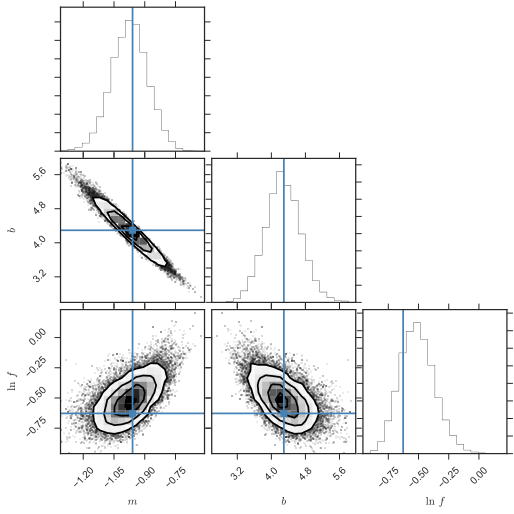

In [48]:
burnin = 50
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])

## Emcee with vanilla Metropolis Hastings and diagonal transition matrix

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


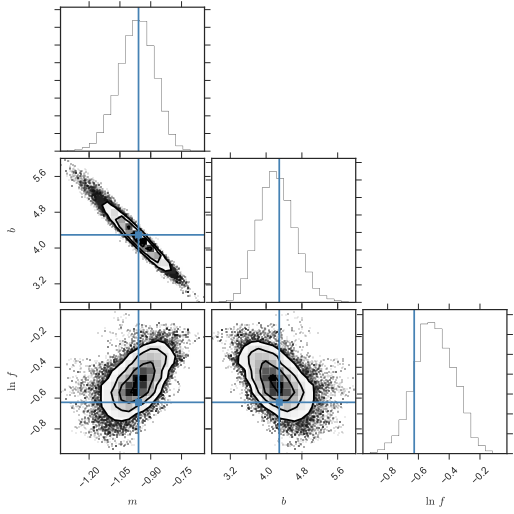

In [49]:
fig = corner.corner(sampler2.chain[n_disc:, :], labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])

## Emcee with Metropolis Hastings and covariant terms in transition matrix

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


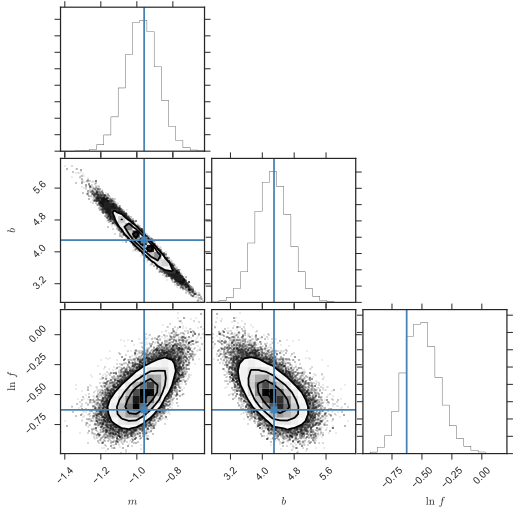

In [50]:
fig = corner.corner(sampler3.chain[n_disc:, :], labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])

So in conclusion, it is easy to use the covariance.  We just need to feed the covariance matrix as an argument to `MHSampler()`.  We can now easily apply this to Starfish.  See the next Notebook where we do that.

# The end.